<b> <center>PROJET PREDICTION DE FAKE NEWS </center>
<br>
<center>M1 SID </center>
    <center>Université Toulouse III</center>
<center>William AZZOUZA / Cyril GAILLARD </center>

Pour obtenir nos prédictions, il suffit de lancer ce code entièrement. Les parties non utilisées ont été mises en commentaires et ne pertuberont donc pas l'exécution du code. Le fichier texte contenant nos prédictions se trouvera à cet endroit : "../data/submsissions/".

#### <u>Importation des librairies utiles</u>

In [1]:
#Partie générale
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from os.path import basename
import warnings
warnings.simplefilter("ignore")

#Partie Texte
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
import sklearn.decomposition as skld
from sklearn.model_selection import KFold
from datetime import datetime

#Partie Réseau 
import networkx as nx

#Partie Machine Learning
#Dans ces imports se trouvent la liste des classifieurs que nous avons essayé pour prédire ; 
#nous n'en avons cependant conserver qu'un.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### <u>Fonctions servant pour lire les différents fichiers textes

In [2]:
#Fonction récupérant les articles
#Input : un chemin
#Output : Un dataFrame contenant le contenu des articles ainsi que leurs ids
def create_lists(path):
    files = glob.glob('../data/news/'+path+'/*.txt')   
    id_articles = []
    articles_contents = []
    for file in files:
        id_article = (basename(file).split(".")[0]);
        article = open('../data/news/'+path+'/'+id_article+'.txt','r', encoding='utf-8').read()
        id_articles.append(int(id_article))
        articles_contents.append(article)
    return pd.DataFrame(articles_contents,columns=['content'],index=id_articles)


#Fonction récupérant le Ytrain
#Input : /
#Output : un dataframe contenant Ytrain
def get_Y_train():
    true_val = []
    indexes = []
    articles = open('../data/labels_training.txt','r').readlines()[1:]
    for i in articles:
        true_val.append(int(i.split(',')[1][:-1]))
        indexes.append(int(i.split(',')[0]))
    return pd.DataFrame(true_val,columns=['fake_news'],index=indexes)


#### <u>Fonctions servant pour la partie texte

In [3]:
#Fonction nettoyant les articles
#Input : un article
#Output : un article "nettoyé"
def sentense2cleanTokens(sent):
    sent = sent.lower()
    sent = "".join([x if x.isalpha() else " " for x in sent])
    sent = " ".join(sent.split())
    return sent

#### <u>Fonction servant pour la partie réseau

In [4]:
# Renvoie les informations relatives aux centralités en degré calculé sur un graphique dirigé
# input : les noeuds, les arcs, les users et le nombre de user que l'on sélectionne
# output : nombre de users importants par article, id des articles partagés par des users influents
def get_network_features(nodes,edges,news_users, number_top):
    
    # Initialisation du graphique directionnel
    graph = nx.DiGraph()

    # Ajout des noeuds
    for node in nodes:
        graph.add_node(node)

    # Ajout des arcs
    for edge in edges.values:
        graph.add_edge(edge[0],edge[1])
    
    # Calcul des centralités selon la méthode de degré pour selectionner les noeuds les plus "centraux/importants"
    calculated_centralities = pd.DataFrame(nx.degree_centrality(graph),index=['Degree']).T
    top_degree = calculated_centralities['Degree'].sort_values()[len(calculated_centralities)-number_top:len(calculated_centralities)+1].index
    
    
    id_article = []
    for new_user in news_users.values:
        # Si le user fait partie des "meilleurs" noeuds selon la centralité degré calculé précédemment
        if new_user[1] in top_degree:
            id_article.append(new_user[0])
    id_article = pd.DataFrame(id_article,columns=['id_article'])
    
    # Liste contenant le nombre d'utilisateurs "importants"
    nb_important_users = id_article['id_article'].value_counts().values 
    # Liste contenant les id_article associés aux nombres précédents
    id_relevant_article = id_article['id_article'].value_counts().index 
    
    return nb_important_users,id_relevant_article, graph

#### <u>Récupération des fichiers

In [5]:
# Récupération des données Xtrain et Xtest
X_train_contents = create_lists('training').sort_index()
X_test_contents = create_lists('test').sort_index()
X_train_ids, X_test_ids = X_train_contents.index.tolist(), X_test_contents.index.tolist()
X_train_contents, X_test_contents = X_train_contents['content'].tolist(), X_test_contents['content'].tolist()

# Récupération du Ytrain
Y_train = get_Y_train().sort_index()
Y_train = list(Y_train['fake_news']) 

# Partie texte

Après avoir récupéré les données brutes, nous avons procédé à un nettoyage de celles-ci afin supprimer la ponctuation, les majuscules ainsi que les caractères spéciaux.

In [6]:
X_train = [sentense2cleanTokens(article) for article in X_train_contents]
X_test = [sentense2cleanTokens(article) for article in X_test_contents]

Une fois nos données nettoyées, nous avons créé la matrice CountVectorizer associé à nos articles. 
<br>Nous avons essayé un grand nombre de combinaisons de paramètres afin de trouver ceux qui nous donnés la meilleure prédiction.
<br>Nous avons comparé nos résultats obtenus avec ceux obtenus en utilisant la matrice tfidf et les résultats se sont avérés meilleurs avec CountVectorizer. Nous avons donc conservé cette dernière méthode ; elle avait aussi pour avantage d'accélérer le temps d'exécution du code.

In [7]:
#vec = TfidfVectorizer(max_df=0.9, min_df=0.1, max_features=100000, stop_words='english')
vec = CountVectorizer(max_df=0.9, min_df=0.1, max_features=100000, stop_words='english') 
X = vec.fit_transform(X_train + X_test)
df = pd.DataFrame(X.toarray(), index=X_train_ids + X_test_ids, columns=vec.get_feature_names())

Nous avons ensuite réfléchi à différentes features qui pourrait améliorer nos prédictions, nous avons alors pensé que la longueur de la plus grande phrase aurait peut être un impact significatif sur nos prédictions.
<br> Il s'est en effet avéré que cette feature avait un réel impact sur notre modèle.
<br> Pour créer cette feature, nous avons dû nous baser sur les données non nettoyées sinon on ne pouvait pas déterminer le début et la fin d'une phrase à cause de la suppression de la ponctuation.
<br><br><u><b>Ajout de la taille de la plus grande phrase :</i></b></u>

In [8]:
larger_sentence = []
for article in X_train_contents:
    max_sentence = 0
    for sentence in article.split("."):
        if len(sentence) > max_sentence:
            max_sentence = len(sentence)
    larger_sentence.append(max_sentence)
for article in X_test_contents:
    max_sentence = 0
    for sentence in article.split("."):
        if len(sentence) > max_sentence:
            max_sentence = len(sentence)
    larger_sentence.append(max_sentence)

Nous avons ensuite ajouté le nombre de phrases que contenait chaque article car nous avons constaté 
que cet élément avait un impact important pour notre modèle.
<br><br><u><b>Ajout du nombre de phrases :</i></b></u>

In [9]:
number_sentence = []
for article in X_train_contents:
    number_sentence.append(len(article.split(".")))
for article in X_test_contents:
    number_sentence.append(len(article.split(".")))    

Nous avons ensuite ajouté la longueur de chaque article qui avait une influence sur nos prédictions.
<br>Pour cette feature, on se base sur les données nettoyées afin que les caractères spéciaux ne fausse pas 
nos résultats.
<br><br><u><b>Ajout de la longueur des articles :</i></b></u>

In [10]:
article_length = []
for article in X_train:
    article_length.append(len(article))
for article in X_test:
    article_length.append(len(article))

Nous avons ensuite ajouté la longueur de la première phrase de l'article. Nous avons pensé que cela pouvait avoir une influence car cette phrase correspondait au titre ou bien à la phrase d'accroche de l'article.
<br><br><u><b>Ajout de la longueur de la première phrase de l'article :</i></b></u>

In [11]:
title_length = []
for article in X_train_contents:
    title_length.append(len(article.split('\n')[0]))
for article in X_test_contents:
    title_length.append(len(article.split('\n')[0]))

Nous avons ensuite ajouté le nombre de mot présent dans chaque article.
<br><br><u><b>Ajout du nombre de mots présent dans chaque article :</i></b></u>

In [12]:
number_word = []
for article in X_train_contents:
    number_word.append(len(article.split(' ')))
for article in X_test_contents:
    number_word.append(len(article.split(' ')))

Nous avons ensuite ajouté le nombre de mots commençant par une majuscule présents dans chaque article.
<br><br><u><b>Ajout du nombre de mots commençant par une majuscule :</i></b></u>

In [13]:
number_entity = []
for article in X_train_contents:
    number = 0
    for word in article.split(' '):
        if word[:1].isupper() or word.isupper():
             number += 1
    number_entity.append(number)
for article in X_test_contents:
    number = 0
    for word in article.split(' '):
        if word[:1].isupper() or word.isupper():
             number += 1
    number_entity.append(number)

Nous avons ensuite ajouté la longueur de la dernière phrase de l'article. Nous avons pensé que cela pouvait avoir une influence car cette phrase est tout aussi importante que la première, elle sert de conclusion à l'article
<br><br><u><b>Ajout de la longueur de la dernière phrase de l'article :</i></b></u>

In [14]:
last_sentence_length = []
for article in X_train_contents:
    last_sentence_length.append(len(article.split('\n')[-1]))
for article in X_test_contents:
    last_sentence_length.append(len(article.split('\n')[-1]))

### Ce qu'on a essayé mais qui n'a pas été utilisé dans le modèle final</b></u>

On a essayé de compter le nombre de type de mots, par exemple le nombre de noms communs dans chaque article grâce à la librairie NLTK. On a essayé avec plusieurs catégories de mots mais cela s'est montré ineficace pour nos prédictions. Nous avons donc décidé de ne pas l'implémenter afin de ne pas surcharger note code avec des éléments inutiles.

In [15]:
"""from nltk import ne_chunk, pos_tag, word_tokenize
nb_nnp = []
for article in X_train_contents:
    cpt = 0
    for i in pos_tag(word_tokenize(article)):
        if i[1] in ['NNP'] :
            cpt += 1
    nb_nnp.append(cpt)
for article in X_test_contents:
    cpt = 0
    for i in pos_tag(word_tokenize(article)):
        if i[1] in ['NNP']:
            cpt += 1
    nb_nnp.append(cpt)
df['number_nnp'] = nb_nnp"""

"from nltk import ne_chunk, pos_tag, word_tokenize\nnb_nnp = []\nfor article in X_train_contents:\n    cpt = 0\n    for i in pos_tag(word_tokenize(article)):\n        if i[1] in ['NNP'] :\n            cpt += 1\n    nb_nnp.append(cpt)\nfor article in X_test_contents:\n    cpt = 0\n    for i in pos_tag(word_tokenize(article)):\n        if i[1] in ['NNP']:\n            cpt += 1\n    nb_nnp.append(cpt)\ndf['number_nnp'] = nb_nnp"

On a également essayé de déterminer le nombre de pays qui était mentionné dans chaque article. Cette feature n'était pas très importante pour notre modèle.

In [16]:
"""import pycountry
list_countries = []
for country in list(pycountry.countries):
    list_countries.append(country.name)
nb_countries = []
for article in X_train_contents:
    cpt = 0
    for word in article.split():
        if word in list_countries:
            cpt += 1
    nb_countries.append(cpt)
for article in X_test_contents:
    cpt = 0
    for word in article.split():
        if word in list_countries:
            cpt += 1
    nb_countries.append(cpt)
df['number_countries'] = nb_countries"""

"import pycountry\nlist_countries = []\nfor country in list(pycountry.countries):\n    list_countries.append(country.name)\nnb_countries = []\nfor article in X_train_contents:\n    cpt = 0\n    for word in article.split():\n        if word in list_countries:\n            cpt += 1\n    nb_countries.append(cpt)\nfor article in X_test_contents:\n    cpt = 0\n    for word in article.split():\n        if word in list_countries:\n            cpt += 1\n    nb_countries.append(cpt)\ndf['number_countries'] = nb_countries"

On a également essayé d'utiliser la méthode k_means afin de classifier nos articles. Cependant même en essayant différentes valeurs pour le nombre de clusters, les résultats obtenus étaient moins bons, nous n'avons donc pas conserver cette feature.

In [17]:
"""num_clusters = 10
km = KMeans(n_clusters=num_clusters)
%time km.fit(df)
clusters = km.labels_.tolist()
df['clusters'] = clusters"""

"num_clusters = 10\nkm = KMeans(n_clusters=num_clusters)\n%time km.fit(df)\nclusters = km.labels_.tolist()\ndf['clusters'] = clusters"

### On ajoute toutes les features précédemment calculées à notre DataFrame

In [18]:
df['larger_sentence']= larger_sentence
df['number_sentence'] = number_sentence
df['article_length'] = article_length
df['title_length'] = title_length
df['number_word'] = number_word
df['number_entity'] = number_entity
df['last_sentence_length'] = last_sentence_length

# Partie Réseau

<b><u>Utilisation des fichiers newsUser.txt et UserUser.txt</u></b>

In [19]:
newsUser = open('../data/newsUser.txt','r').readlines()
UserUser = open('../data/UserUser.txt','r').readlines()

In [20]:
news_users = pd.DataFrame([line.split() for line in newsUser], columns=['id_article','id_user','number_propagation'])
news_users['number_propagation'] = [int(propagation) for propagation in news_users['number_propagation']]

In [21]:
User_User = pd.DataFrame([line.split() for line in UserUser],columns=['follower','followed'])
id_followed = User_User['followed'].unique()
id_follower = User_User['follower'].unique()

La première feature à laquelle nous avons pensé après avoir regardé le fichier newsUser.txt était le nombre de propagation de chaque article. Nous avons donc fait une somme de toutes les propagations pour chaque article.
<br><br><u><b>Ajout du nombre de propagations de l'article :</i></b></u>

In [22]:
propagation_number = []
for id_article in df.index:
    propagation_number.append( \
    news_users[['id_article', \
    'number_propagation']].groupby(['id_article']).sum()['number_propagation'].loc[str(id_article)])

<u><b>Création des réseaux utilisateurs :</i></b></u></b>

Nous avons ensuite fait le choix de créer un réseau d'utilisateurs dans le but d'essayer d'améliorer nos prédictions.
C'est un graphique dirigé, de la forme utilisateur est suivi par tels utilisateurs.

Nous nous basons sur une centralité sur le degré. Sur un graphe dirigé elle permet d'identifier le nombre de voisins divisé par tous les voisins possibles qu'il pourrait avoir. Nous allons nous servir de la fonction degree_centrality afin de récupérer ces valeurs.
Ces valeurs vont nous permettre de déterminer les 5000 utilisateurs les plus suivis, feature qu'on essaiera d'ajouter à notre dataframe.

<i>On va dans un premier temps déterminer les 5000 utilisateurs les plus suivis (important_followed) dans le but de compter leur nombre de ces important_followed pour chaque partage d'articles. Nous voulons en fait étudier les articles les plus partagés par cette communauté d'important_follower. Le nombre 5000 a été choisi suite à un très grand nombe de tests, c'est ce nombre qui maximisait notre score.

In [23]:
nb_important_users_followed,id_relevant_article_followed, graph1 = get_network_features(id_followed,User_User,news_users, 5000)

<i> Ensuite on cherche dans les 5000 utilisateurs (important_follower) qui suivent le plus  d'autres utlisateurs. Le but étant d'identifier les articles les plus partagés par ce groupe d'important_follower. Le nombre 5000 a été choisi suite à un très grand nombe de tests, c'est ce nombre qui maximisait notre score.

In [24]:
nb_important_users_follower,id_relevant_article_follower, graph2 = get_network_features(id_follower,User_User,news_users, 5000)

<u><b> On ajoute nos features crée à partir des réseaux utilisateurs :

In [25]:
df['number_important_user_followed'] = 0
for i in tqdm(range(len(id_relevant_article_followed))):
    df['number_important_user_followed'].loc[int(id_relevant_article_followed[i])] \
    = nb_important_users_followed[i]
    
df['propagation_number'] = propagation_number

df['number_important_user_follower'] = 0
for i in tqdm(range(len(id_relevant_article_follower))):
    df['number_important_user_follower'].loc[int(id_relevant_article_follower[i])] = nb_important_users_follower[i]

On a remarqué que les nombres des deux colonnes précédentes étaient dans la plupart des cas les mêmes sauf dans certains cas, nous avons quand même décidé de laisser ces deux features

<u><b>Ce qu'on a essayé mais qui n'a pas été utilisé dans le modèle final</b></u>

On a essayé de faire des communautés d'utilisateurs mais le réseau était trop grand, le temps d'exécution était donc trop conséquent (interminable pour nos machines). Même en essayant tous les algos, aucun ne se lancé, le réseau est trop conséquent pour être supporté par nos machines.

# Partie Machine Learning

#### Séparation de notre dataframe en deux df : train / test

In [26]:
df_train = pd.DataFrame(df.loc[X_train_ids])
df_test = pd.DataFrame(df.loc[X_test_ids])

Afin d'essayer de déterminer les features qui contribuaient le plus à notre modèle, nous avons créé un graphique nous montrant les 30 features les plus importantes pour notre modèle. On déduit bien de ce graphique que toutes les features que nous avons décidé d'ajouter sont présentes dans les 30 plus importantes. Nous avons donc bien choisi nos features.
<br>Concernant le choix de l'algorithme de classifieur à utiliser, nous avon fait énormément de tests. Nous avons testé tous les algorithmes et le plus robuste avec nos données a été le RandomForestClassifier(), c'est donc celui-ci que nous utilisons pour faire nos prédictions. Nous avons essayer plusieurs combinaisons de paramètres afin de trouver ceux que l'on trouvait "optimaux".

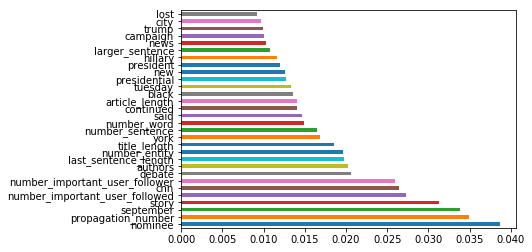

In [27]:
#### Contribution de nos features
model = RandomForestClassifier(random_state= 42, criterion = 'gini',  \
                               n_estimators= 1400, min_samples_split= 2, \
                               min_samples_leaf= 1, max_features='auto', \
                               max_depth= 30, bootstrap= False)
model.fit(df_train, Y_train)
feat_importances = pd.Series(model.feature_importances_, index=df_train.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

Entrainement de notre modèle, utilisation d'une cross validation pour évaluer notre modèle.

In [28]:
model = RandomForestClassifier(random_state = 42, criterion = 'gini',  \
                               n_estimators= 1400, min_samples_split= 2, \
                               min_samples_leaf= 1, max_features='auto', \
                               max_depth= 30, bootstrap= False)
pred = np.mean(cross_val_score(model, df_train, Y_train, cv=10))
print(pred)
clf_rfc = RandomForestClassifier(random_state = 42, criterion = 'gini',  \
                                 n_estimators= 1400, min_samples_split= 2, \
                                 min_samples_leaf= 1, max_features= 'auto', \
                                 max_depth= 30, bootstrap= False)
clf_rfc.fit(df_train, Y_train)

0.8817251461988305


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Pour générer le fichier résultat

In [29]:
#Prédiction avec notre modèle sur les données tests
pred_test = clf_rfc.predict(df_test)

In [30]:
now = datetime.now()
now = now.strftime("%d-%m-%Y_%H-%M-%S")
#Création du fichier txt
fichier = open("../data/submissions/pred_test_"+now+".txt", "a")
#En tête du fichier
fichier.write("doc,class")
#On parcourt notre liste et on inscrit les prédictions au bon format
for i in range(len(pred_test)):
    fichier.write("\n" + str(X_test_ids[i]) + ',' + str(pred_test[i]))
fichier.close()

# <center>FIN</center>